# Lab 2C: Classification

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys

import matplotlib.pyplot as plt
import IPython.display as ipd

import os
import numpy as np
device = "cpu"


A classification is a partition of reality. Given realizations $x$ of some object we ascribe to each of them a unique label $y_c$ that marks them as members of class $c$. In a classification task we want to train an artificial intelligence that when presented with an input $x$ predicts a class label $\hat{y}$ that matches the label $y_c$ ascribed by the real world.

To model classification as empirical risk minimization (ERM) we just need to define a proper loss. The easiest is to define a hit loss that takes the value $\ell(y, \hat{y}) = 1$ when $\hat{y} \neq y$ and the value $\ell(y, \hat{y}) = 0$ when $\hat{y} = y$. To write this loss formally we define the indicator function $I ( y = y_c )$ which takes the values 

$$
   I ( y = y_c ) = 1 \text{~when~} y = y_c, \quad \\
   I ( y = y_c ) = 0 \text{~when~} y \neq y_c.
$$

The previous loss is a reasonable choice but it is not differentiable with respect to the score variable $\hat{s}$. This is a drawback for implementing gradient descent. To solve this problem we define the soft maximum function 

$$
   \text{softmax}(\hat{s})
      = \log \sum_{d=1}^{C} e^{\hat{s}_d}.
$$

The soft maximum is a differentiable approximation of the maximum in the sense that $\text{softmax}(\hat{s}) \approx \max_d \hat{s}_d$. We can therefore replace the maximum $\max_d \hat{s}_d$ in \eqref{eqn_max_loss} by the soft maximum function to define the loss

$$

\ell(y, \hat{s}) 
      = \sum_{c=1}^{C} 
         I [ y = y_c ] 
            \times 
               \Big[ \log \sum_{d=1}^{C} e^{\hat{s}_d}  -  \hat{s}_c \Big].
$$

This is the cross entropy loss. Its use in classification tasks is standard.

### Loading and exploring the data

In [2]:
train_audios = torch.load('train_audios_3.pt')
train_labels = torch.load('train_labels_3.pt')
test_audios = torch.load('test_audios_3.pt')
test_labels = torch.load('test_labels_3.pt')
sample_rate = 8000

In [3]:
sample, label = train_audios[0], train_labels[0]

Shape of waveform: torch.Size([1, 8000])
Sample rate of waveform: 8000


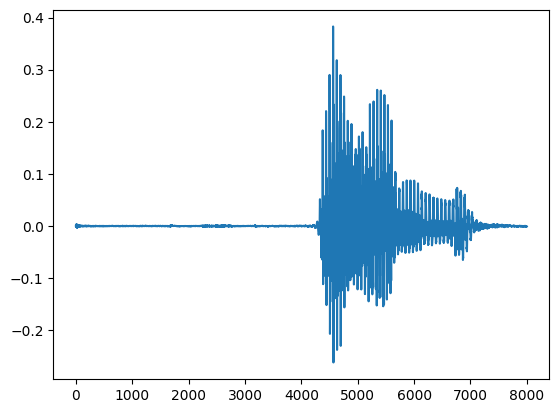

In [4]:
print("Shape of waveform: {}".format(sample.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(sample.squeeze().numpy())

In [5]:
display(ipd.Audio(sample, rate=sample_rate))

In [6]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(train_audios, train_labels),
    batch_size=batch_size,
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(test_audios, test_labels),
    batch_size=batch_size,
    shuffle=False,
)

### CNN architecture: convolutions, non linearities and a readout layer

In Lab 1B we processed audio with a convolutional neural network (CNN). Our CNN was such that if the input signal contains $N$ entries, the output signal contains $N$ entries as well. This is unsuitable for a classification task  in which we want the output to be a vector of scores $s$ containing as many entries as classes.

To sort this out we add a readout layer to match the dimensionalities of the input and output. A readout layer is just a fully connected layer at the output.  Instead of a convolutional filter, the last layer is the fully connected layer,

$$
   \Phi(x; \mathcal{H}) 
      ~=~ x_L 
      ~=~ \sigma \Big(\, A_L x_{L-1} \,\Big) .
$$

If we have input signals $x=x_0$ of dimension $N$ and we have $C$ classes, the matrix $A_L$ is of dimension $C \times N$. This results in an output $\Phi(x; \mathcal{H}) = x_L$ containing $C$ entries that we can equate to the predicted score $s$. 

In \eqref{eqn_readout} we consider a CNN with layers that have a single channel. In practice, we have already seen that we have to use CNNs with multiple channels. This is not a problem but it requires that we reshape the matrix $x_{L-1}$ to turn it into a vector. We do that by stacking the columns of $x_{L-1}$ on top of each other, 

$$
   \text{vec}(x_{L-1}) 
      = \Big[\, x_{L-1}^1;\, x_{L-1}^2;\, \ldots;\, x_{L-1}^{F_{l-1}} \,\Big] .
$$

This operation has no conceptual significance. It is just a reshaping of data. We need to do this to write the readout layer as the matrix multiplication with $x_{L-1} = \text{vec}(x_{L-1})$.I

Modify the CNN code of Lab2B to endow it with a method that implements a single convolutional layer. Add another method to implement a readout layer. Use these two methods to modify the CNN class to implement a CNN with readout. 

This class receives as initialization parameters the number of layers $L$ and the dimensions $N$ and $C$ of the input features $x$ and the output scores $s$. To specify the $L-1$ convolutional layers we also accept the vectors $[K_1, \ldots, K_{L-1}]$ and $[F_0, F_1, \ldots, F_{L-1}]$ containing the number of taps $K_\ell$ of the filters used at each layer and the number of features $F_\ell$ at the output of each layer. 


The forward method of this class takes a matrix $x$ of dimension $N\times F_0$ as an input and returns the output $\Phi(x; \mathcal{H})$ of a CNN with $L-1$ convolutional layers and a readout layer. The dimension of this output vector is $C$.

We will use PyTorch's implementation of 1-D convolutions: **nn.Conv1D()**. This function takes the same arguments and performs the same operation as the 1-D convolution function we created in lab 1B. However, PyTorch's implemenation is faster and more memory-efficient since it uses a low-level programming language. You can read more about this implemenation in the following link: https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html.


In [7]:
def convolution_1D(signal, conv_filter):
    taps = conv_filter.shape[0]
    out_features = conv_filter.shape[1]
    N = signal.shape[-1]
    z = torch.zeros((out_features, N))
    for k in range(taps):
        z = z + torch.matmul(conv_filter[k] , signal)
        signal = signal.roll(1,)
        signal[:,0] = 0
    return z

class convolutional_layer(nn.Module):
    def __init__(self, in_features, out_features, kernel_size):
        super().__init__()
        self.filter = torch.nn.Parameter(torch.empty(kernel_size, out_features, in_features))
        nn.init.xavier_normal_(self.filter)
        
    def forward(self,x):
        return convolution_1D(x, self.filter)
    
class readout_layer(nn.Module):
    def __init__(self, input_length, classes):
        '''
        inputs:
            L (int): number of layers
            taps (list[int]): list with number of taps for each layer
        '''
        super().__init__()
        self.filter = torch.nn.Parameter(torch.empty((classes, input_length)))
        nn.init.xavier_normal_(self.filter)
    
    def forward(self,x):
        return torch.matmul(x,self.filter.T)

class CNN(nn.Module):
    def __init__(self, n_input=1, n_output=3, n_channel=[8, 8], kernel_sizes = [80, 3]):
        super().__init__()
        input_length = 8000
        emb_dim = n_channel[1]*input_length
        self.conv1 = nn.Conv1d(n_input, n_channel[0], kernel_size=kernel_sizes[0], padding='same') 
        # Setting the argument padding='same' implies that output features have the same dimension as input features
        self.conv2 = nn.Conv1d(n_channel[0], n_channel[1], kernel_size=kernel_sizes[1], padding='same')
        self.fc1 = readout_layer(emb_dim, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = torch.flatten(x, start_dim=1) #Vectorization operation
        x = self.fc1(x)
        return x


### Task 2
Load the data from which contains audio samples in which people are speaking digits from $0$ to $2$. Train a CNN with a readout layer to classify the audio signals into the different possible spoken digits. 

In [8]:
def train(model, epoch, log_interval):
    cross_entropy = nn.CrossEntropyLoss()
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        output = model(data).squeeze()

        loss = cross_entropy(output, target.type(torch.LongTensor).to(device))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} \tLoss: {loss.item():.3f}")

        # record loss
        losses.append(loss.item())

In [9]:
def number_of_correct(pred, target):
    num_correct = torch.sum(pred == target)
    return num_correct

def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)

def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")
    return correct/len(test_loader.dataset)

CNN(
  (conv1): Conv1d(1, 8, kernel_size=(80,), stride=(1,), padding=same)
  (conv2): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=same)
  (fc1): readout_layer()
)
Number of parameters: 192848
Train Epoch: 1 	Loss: 1.098


/home/elenter/miniconda3/envs/dcase/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
  return F.conv1d(input, weight, bias, self.stride,


Train Epoch: 1 	Loss: 1.105
Train Epoch: 1 	Loss: 1.100

Test Epoch: 1	Accuracy: 418/1241 (34%)

Train Epoch: 2 	Loss: 1.093
Train Epoch: 2 	Loss: 1.089
Train Epoch: 2 	Loss: 1.093

Test Epoch: 2	Accuracy: 430/1241 (35%)

Train Epoch: 3 	Loss: 1.082
Train Epoch: 3 	Loss: 1.092
Train Epoch: 3 	Loss: 1.080

Test Epoch: 3	Accuracy: 586/1241 (47%)

Train Epoch: 4 	Loss: 1.093
Train Epoch: 4 	Loss: 1.065
Train Epoch: 4 	Loss: 1.075

Test Epoch: 4	Accuracy: 596/1241 (48%)

Train Epoch: 5 	Loss: 1.073
Train Epoch: 5 	Loss: 1.044
Train Epoch: 5 	Loss: 1.022

Test Epoch: 5	Accuracy: 584/1241 (47%)



Text(0.5, 1.0, 'training loss')

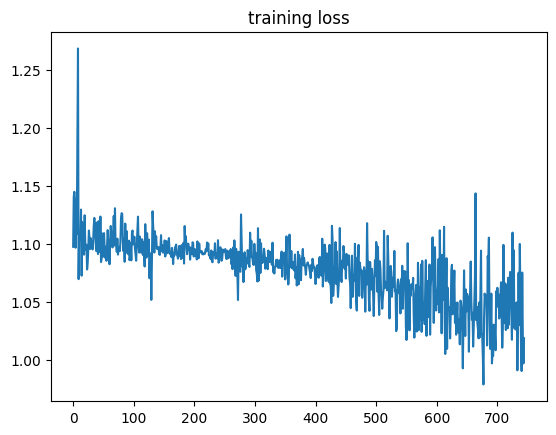

In [10]:
log_interval = 50
n_epoch = 5

model = CNN(n_input=1, n_output=3, n_channel=[8, 8], kernel_sizes = [80, 3])
model.to(device)
print(model)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

n = count_parameters(model)
print("Number of parameters: %s" % n)

optimizer = optim.SGD(model.parameters(), lr=0.01)

losses = []
test_acc = []

for epoch in range(1, n_epoch + 1):
    train(model, epoch, log_interval)
    test_acc.append(test(model, epoch))

# Let's plot the batch training loss versus the number of iteration.
plt.plot(losses)
plt.title("training loss")

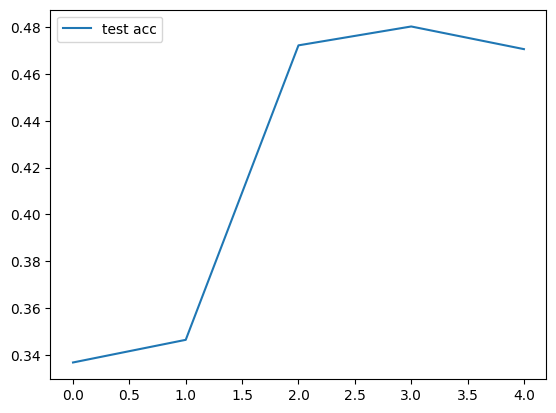

In [11]:
plt.plot(test_acc, label = 'test acc')
plt.legend()

Pooling operators reduce the dimension of the input signal while retaining the structure of time. They do so by introducing a reduction factor $\Delta$, dividing the time line in windows of width $\Delta$, and extracting information from every window (Figure \ref{fig_pooling}). 

The simplest form of pooling is sampling. Let $w=[w_0; w_1;\ldots;w_{N-1}]$ be a signal with $N$ components. We define the sampled signal as the signal $x=[x_0; x_1;\ldots;x_{N_s}]$ in which the component $x_m$ is given by
$$
   x_m ~=~ w_{m\Delta} ~.
$$
Thus, the sampled signal $x$ copies one out of $\Delta$ entries of $w$ and ignores the rest. The rationale for ignoring entries is that the values of entries in a window, say $w_{m\Delta}$ and $w_{m\Delta+1}$, are not very different and we loose little information by discarding some of them.

In general, computing some aggregate summary of the entries in a pooling window is more effective than plain sampling. Average pooling replaces the entries in each pooling window by their average,

$$
   x_m 
      ~=~ \frac{1}{\Delta}
             \Big( \,
                w_{m\Delta} +  
                   w_{m\Delta+1} + 
                      \ldots + 
                         w_{m\Delta+(\Delta-1)}
                             \,\Big) ~.
$$

Another common approach to summarizing entries in a pooling window is to compute the maximum value,
%
$$
   x_m 
      ~=~ \max
             \Big( \,
                w_{m\Delta} ,\,  
                   w_{m\Delta+1} ,\, 
                      \ldots ,\, 
                         w_{m\Delta+(\Delta-1)}
                             \,\Big) ~.
$$
This is called max pooling. Max pooling is more common than average pooling and both are more common than sampling. In any case, pooling is effective when the signal $w$ does not change much within the pooling window. When this is the case, sampling, average pooling, and max pooling all produce similar summary signals $x$.

The pooling operations in \eqref{eqn_sampling}-\eqref{eqn_max_pooling} apply to individual vectors. In CNNs we want to pool multiple features. This is done by pooling each feature individually. Given the matrix feature $w=[w^1; w^2;\ldots;w^{F}]$ the pooled matrix feature $x=[x^1; x^2;\ldots;x^{F}]$ contains the same number of features $F$ and is such that each of the individual vector features $x^f$ is pooled separately. Thus, Component $m$ of Feature $f$ is given by
$$ 
   x_m^f 
      ~=~ \text{pool}
             \Big( \,
                w^f_{k\Delta} ,\,  
                   w^f_{k\Delta+1} ,\, 
                      \ldots ,\, 
                         w^f_{k\Delta+(\Delta-1)}
                             \,\Big) ~,
$$
where the operation $\text{pool}(\cdot)$ stands in for either sampling, average pooling or max pooling.

### Task
Modify the CNN to incorporate pooling. This can be done by modifying the method that implements convolutional layers to incorporate the pooling operation. 

As in any CNN the initialization parameters include the number of layers $L$ along with vectors $[K_1, \ldots, K_{L-1}]$ and $[F_0, F_1, \ldots, F_{L-1}]$. These vectors contain the number of taps $K_\ell$ of the filters used at each layer and the number of features $F_\ell$ at the output of each layer. 

Since we are incorporating pooling the initialization parameters must also include the vecor $[N_0, N_1, \ldots, N_{L}]$ containing the dimension $N_\ell$ of the features at the output of each layer. Notice that $N_0$ matches the dimension of the input signal and $N_L=C$ matches the number of classes.

The forward method of this class takes a matrix $x$ of dimension $N_0\times F_0$ as an input and returns the output $\Phi(x; \mathcal{H})$ of a CNN with $L-1$ convolutional layers and a readout layer. The dimension of this output is $N_L \times 1$.

Use relu nonlinearities in all layers. Use max pooling in all convolutional layers where pooling is implemented.  $\blacksquare$

### Naive pooling implementations

In [ ]:
def average_pooling_naive(signal = torch.rand(32, 2, 80), poolsize = 4):
    output_length = int(signal.shape[-1]/poolsize)
    pooled_signal = torch.empty((signal.shape[0], signal.shape[1], output_length))
    for i in range(output_length):
        start = i*poolsize
        end = start + poolsize
        pooled_signal[:,:,i] = torch.mean(signal[:,:,start:end],dim=2).values
    return pooled_signal

def max_pooling_naive(signal = torch.rand(32, 2, 80), poolsize = 4):
    output_length = int(signal.shape[-1]/poolsize)
    pooled_signal = torch.empty((signal.shape[0], signal.shape[1], output_length))
    for i in range(output_length):
        start = i*poolsize
        end = start + poolsize
        pooled_signal[:,:,i] = torch.max(signal[:,:,start:end],dim=2).values
    return pooled_signal

### CNN with Pooling, ReLU non-linearities and a readout layer

In [15]:
class max_pool_1d(nn.Module):
    # Implements max pooling in a vectorized, faster fashion.
    def __init__(self, pool_size, device='cpu'):
        super().__init__()
        self.poolsize = pool_size
        self.device = device

    def forward(self, signal):
        output_length = int(signal.shape[-1]/self.poolsize)
        signal = signal.reshape((signal.shape[0], signal.shape[1], output_length, -1)).to(self.device)
        pooled_signal = torch.max(signal,dim=-1).values
        return pooled_signal

class average_pool_1d(nn.Module):
    # Implements the average pooling in a vectorized, faster fashion.
    def __init__(self, pool_size, device='cpu'):
        super().__init__()
        self.poolsize = pool_size
        self.device = device

    def forward(self, signal):
        output_length = int(signal.shape[-1]/self.poolsize)
        signal = signal.reshape((signal.shape[0],signal.shape[1],output_length,-1)).to(self.device)
        pooled_signal = torch.mean(signal,dim=-1)

        return pooled_signal

class CNN(nn.Module):
    def __init__(self, n_input=1, n_output=3, n_channel=[8, 8], kernel_sizes = [80, 3], pooling_windows = [8, 8]):
        super().__init__()
        input_length = 8000
        emb_dim = int(n_channel[1]*input_length/(8*8))
        self.conv1 = nn.Conv1d(n_input, n_channel[0], kernel_size=kernel_sizes[0], padding='same')
        self.pool1 = max_pool_1d(pooling_windows[0])
        self.conv2 = nn.Conv1d(n_channel[0], n_channel[1], kernel_size=kernel_sizes[1], padding='same')
        self.pool2 = max_pool_1d(pooling_windows[1])
        self.fc1 = readout_layer(emb_dim, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = torch.flatten(x, start_dim=1) # Vectorization operation
        x = self.fc1(x)
        return x

CNN(
  (conv1): Conv1d(1, 8, kernel_size=(80,), stride=(1,), padding=same)
  (pool1): max_pool_1d()
  (conv2): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=same)
  (pool2): max_pool_1d()
  (fc1): readout_layer()
)
Train Epoch: 1 	Loss: 1.085
Train Epoch: 1 	Loss: 1.094
Train Epoch: 1 	Loss: 1.107

Test Epoch: 1	Accuracy: 442/1241 (36%)

Train Epoch: 2 	Loss: 1.092
Train Epoch: 2 	Loss: 1.085
Train Epoch: 2 	Loss: 1.101

Test Epoch: 2	Accuracy: 534/1241 (43%)

Train Epoch: 3 	Loss: 1.076
Train Epoch: 3 	Loss: 1.067
Train Epoch: 3 	Loss: 1.110

Test Epoch: 3	Accuracy: 598/1241 (48%)

Train Epoch: 4 	Loss: 1.005
Train Epoch: 4 	Loss: 1.070
Train Epoch: 4 	Loss: 1.101

Test Epoch: 4	Accuracy: 548/1241 (44%)

Train Epoch: 5 	Loss: 1.004
Train Epoch: 5 	Loss: 0.995
Train Epoch: 5 	Loss: 0.895

Test Epoch: 5	Accuracy: 761/1241 (61%)

Train Epoch: 6 	Loss: 0.958
Train Epoch: 6 	Loss: 0.804
Train Epoch: 6 	Loss: 0.871

Test Epoch: 6	Accuracy: 866/1241 (70%)

Train Epoch: 7 	Loss: 0.803
T

Text(0.5, 1.0, 'training loss')

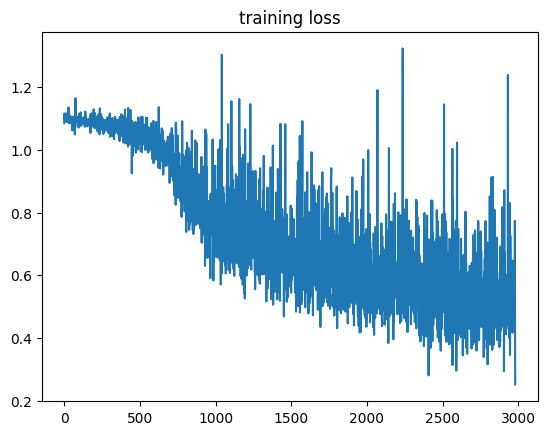

In [16]:
log_interval = 50
n_epoch = 20

model = CNN(n_input=1, n_output=3, n_channel=[8, 8], kernel_sizes = [80, 3])
model.to(device)
print(model)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

optimizer = optim.SGD(model.parameters(), lr=0.03)

losses = []
test_acc = []

for epoch in range(1, n_epoch + 1):
    train(model, epoch, log_interval)
    test_acc.append(test(model, epoch))

# Let's plot the training loss versus the number of iteration.
plt.plot(losses)
plt.title("training loss")

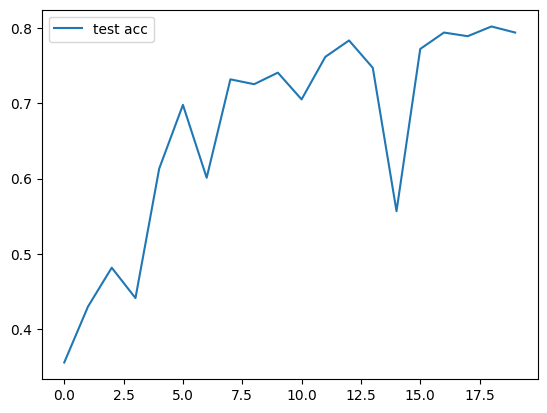

In [17]:
plt.plot(test_acc, label = 'test acc')
plt.legend()